In [112]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 10)

# Анализ входящих данных

In [243]:
data = pd.read_excel("data_oil.xlsx", 0, index_col='Date', parse_cols=1)
data.head()

,Oil
Date,
1946-01-01,15.24
1946-02-01,15.33
1946-03-01,15.16
1946-04-01,16.37
1946-05-01,16.28


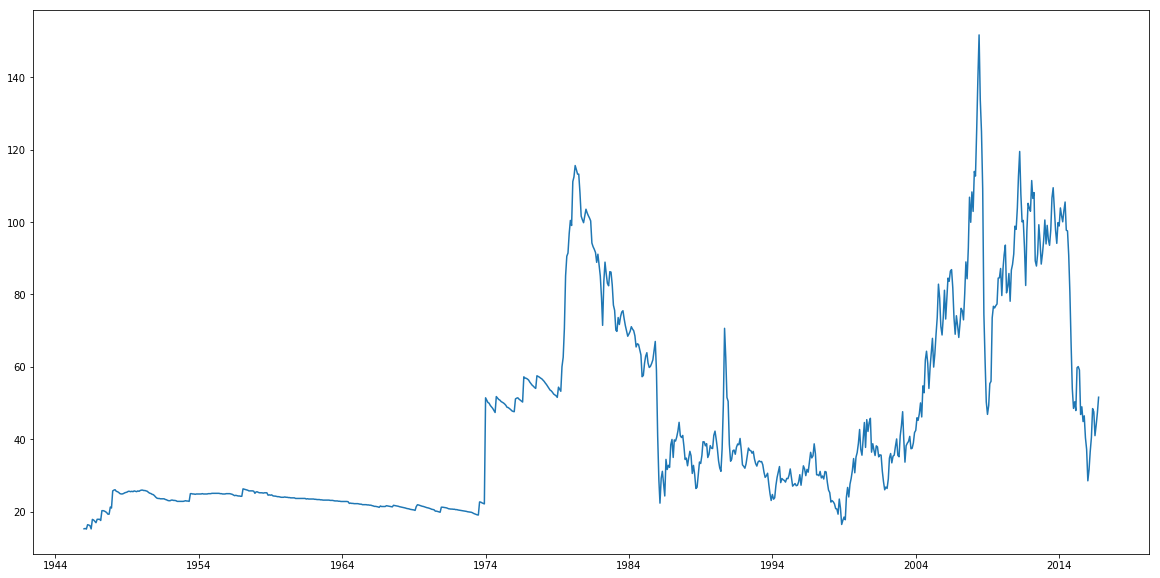

In [244]:
plt.plot(data)

# Проверим на стационарность данные по стоимости нефти (Oil)

В результирующих данных мы получили временной ряд (https://ru.wikipedia.org/wiki/Временной_ряд). Его нужно проанализироват и выявить степень стационарности, прогнозировать имеет смысл только стационарный ряд. Возьмем данные с 1980 года.

In [252]:
data_oil = data['1980-01-01':].filter(["Oil"])
data_oil.dropna(inplace=True)
data_oil.head()

,Oil
Date,
1980-01-01,99.06
1980-02-01,111.19
1980-03-01,112.48
1980-04-01,115.62
1980-05-01,114.51


Для того, чтобы посторить модель предсказания, проверим данные на стационарность. Это значит, что с определенной периодичностью порядок измеряемой величины должн повторятся. Стационарность можно определить построив кривые по показателеям "Среднеквадратичное отклонение (Rolling std)" и "Скользящее среднее (Rolling Mean)", для стационарных величин они не должны менятся. Более формальный подход проверка данных с помощью теста Дики-Фуллера (https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера). В результате теста, если в данных обнаружена стационарность, то величина Test Statisti должна быть меньше Critical Value.

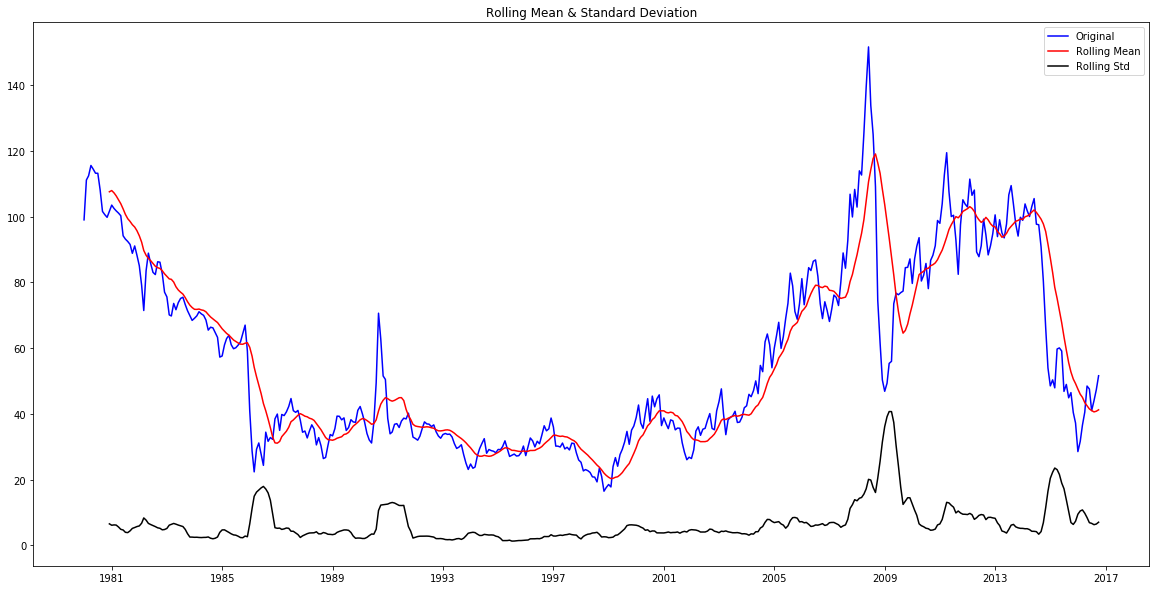

In [265]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    #print('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in dftest[4].items():
    #    dfoutput['Critical Value (%s)'%key] = value
    #print(dfoutput)
    
test_stationarity(data_oil)

# Превращение временного ряда в стационарный

## Логарифмическая трансформация

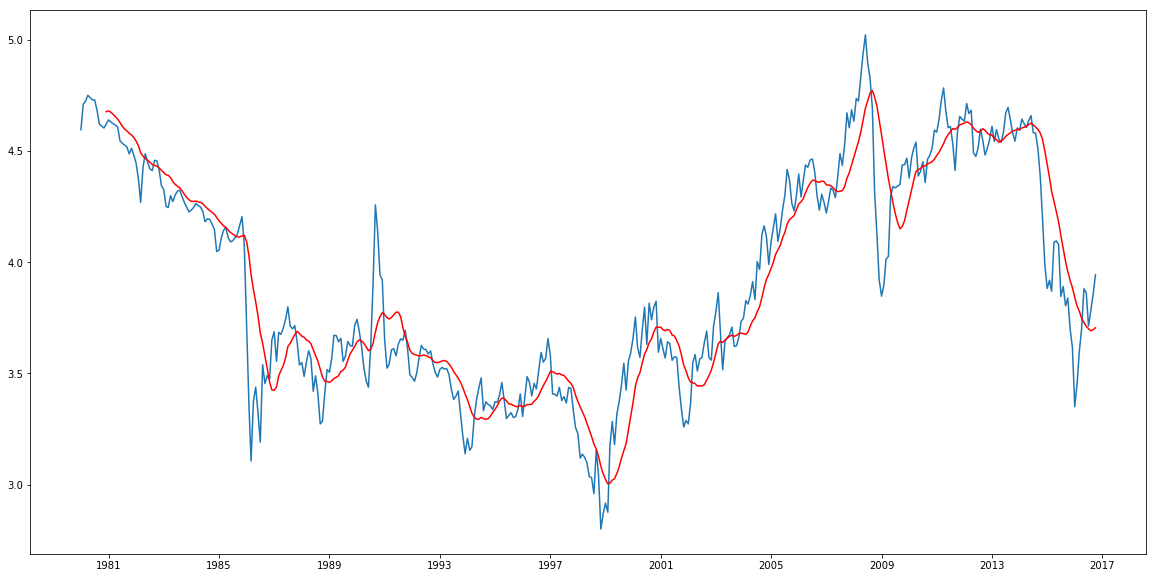

In [271]:
ts_log = np.log(data_oil)
ts_log.dropna(inplace=True)

moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

## Скользящая средняя

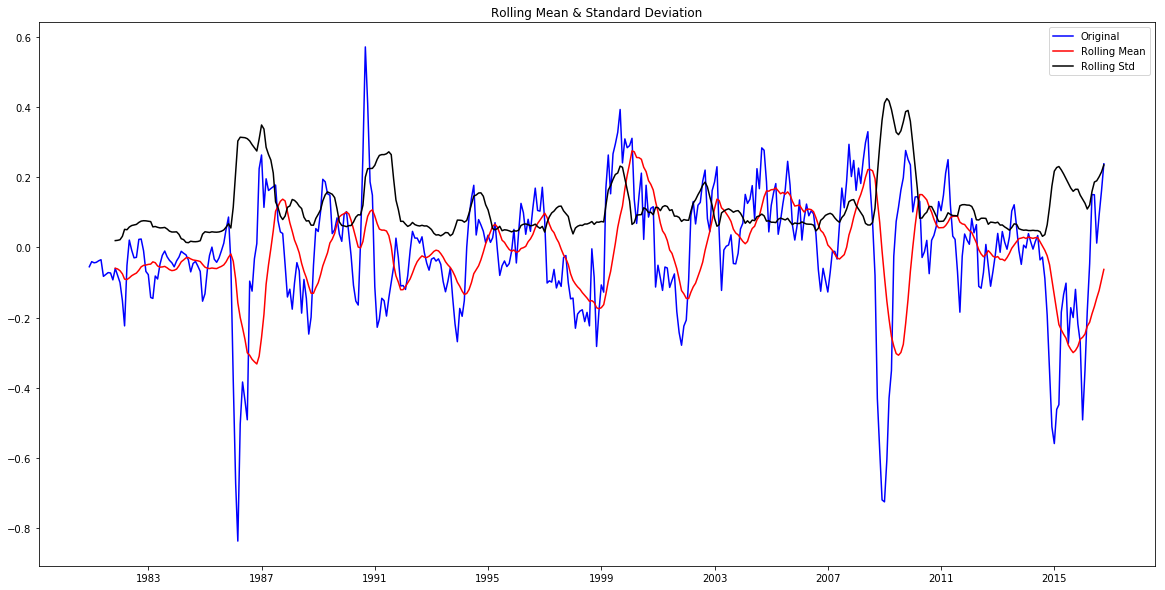

In [278]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Сгладим с помощью "экспоненциально взвешенное скользящим средним"

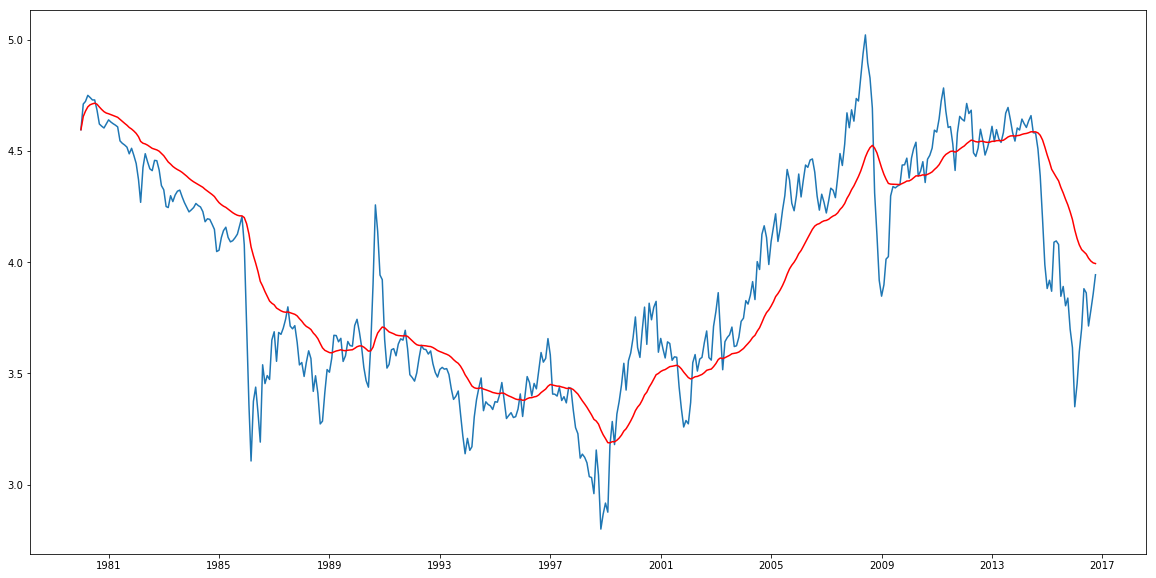

In [273]:
expwighted_avg = data_oil_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

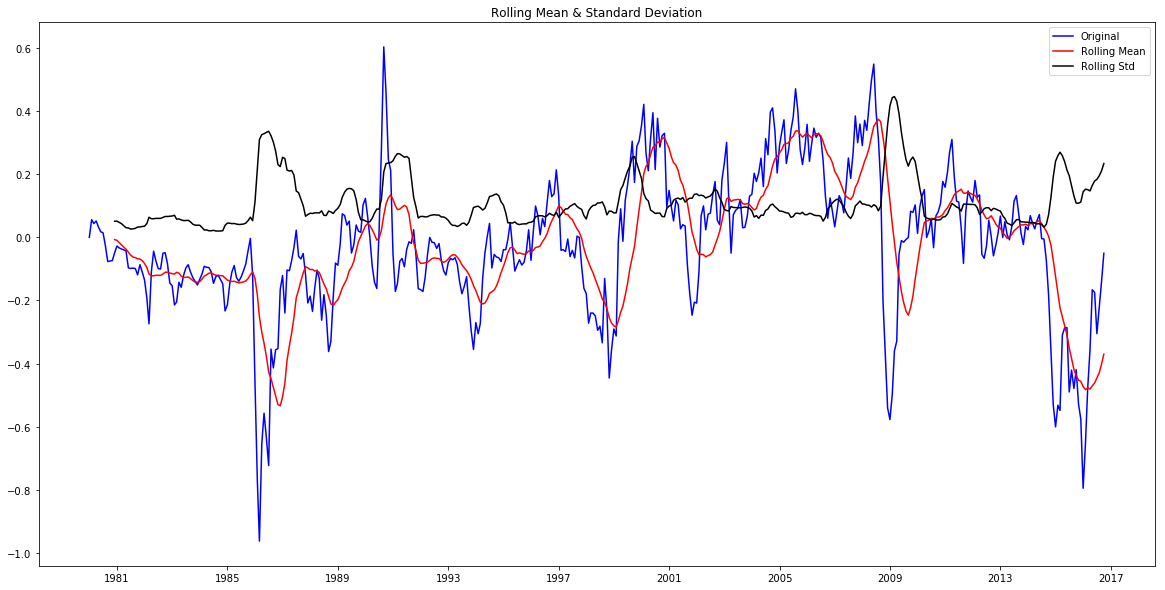

In [279]:
ts_log_ewma_diff = ts_log - expwighted_avg
ts_log_ewma_diff.dropna(inplace=True)
test_stationarity(ts_log_ewma_diff)

# Выявление трендов и сезонности

## Дифференциация

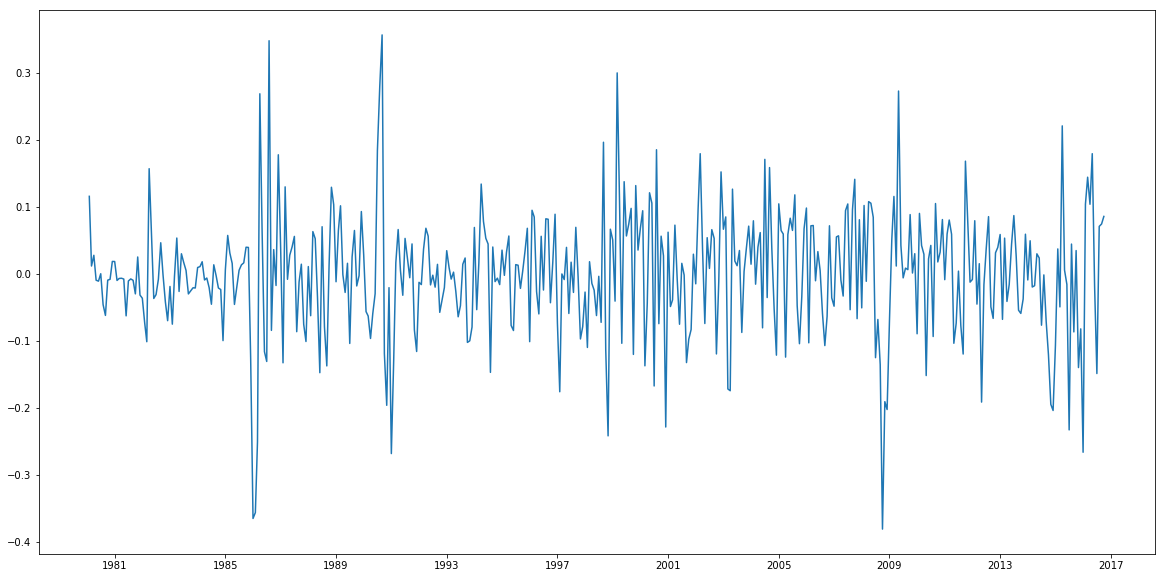

In [275]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

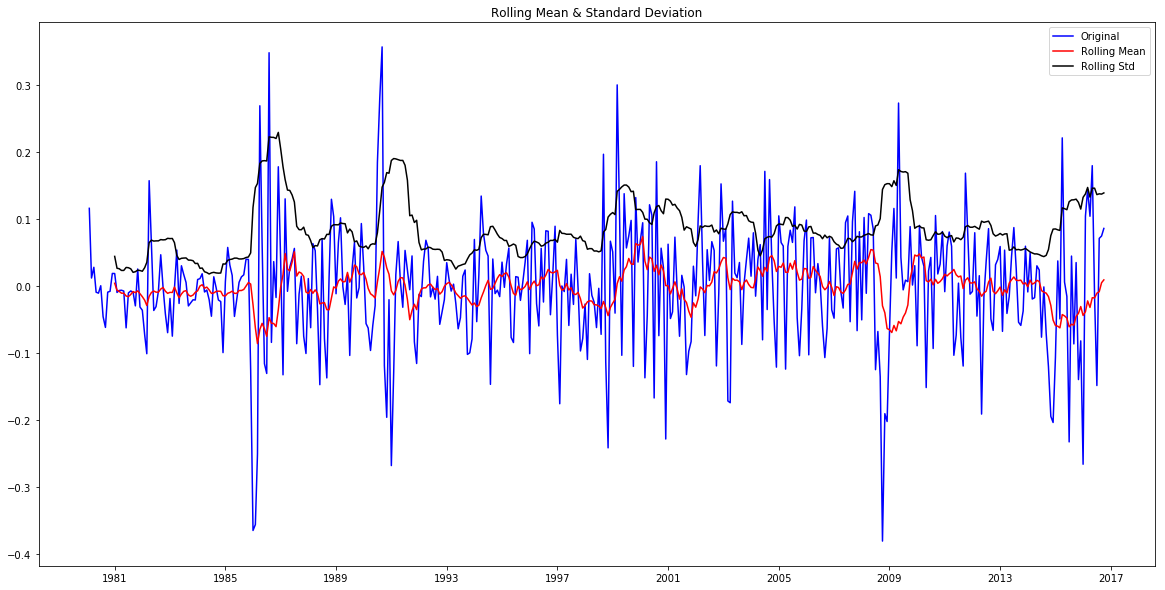

In [276]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Декомпозиция

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


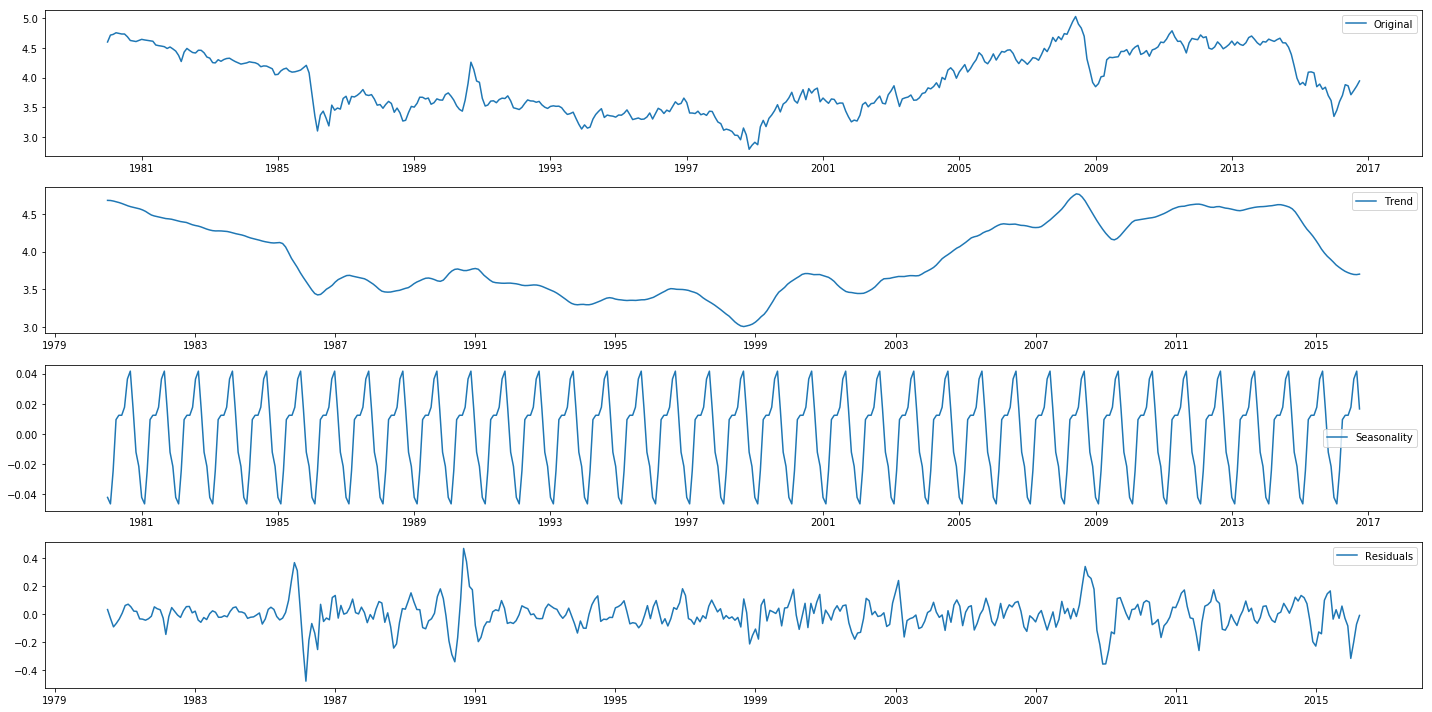

In [280]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

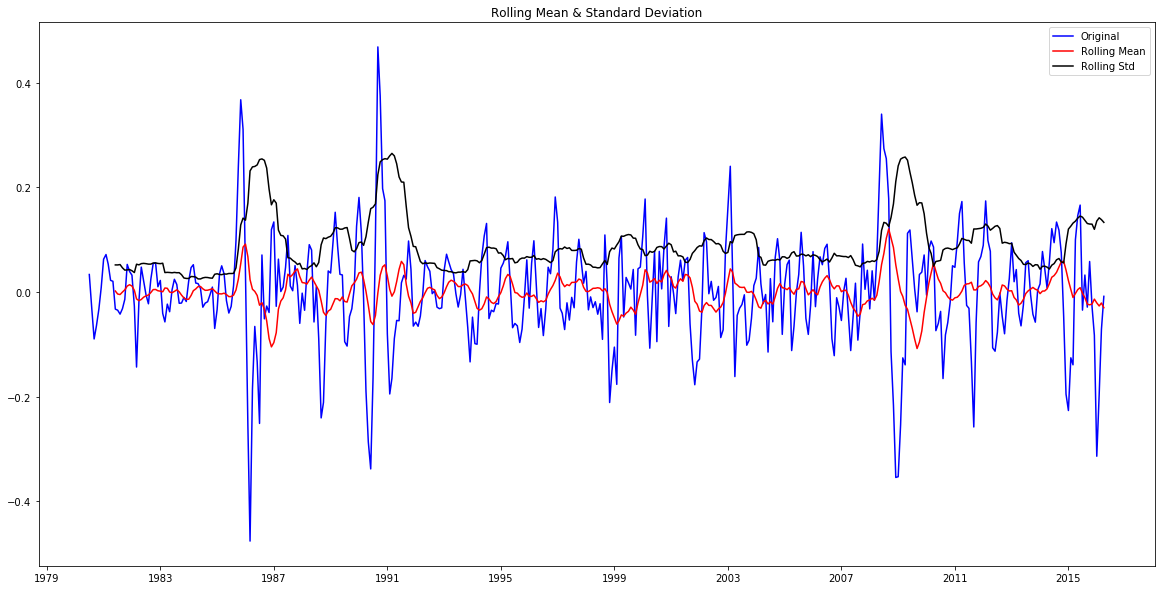

In [281]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Предсказание временных рядов

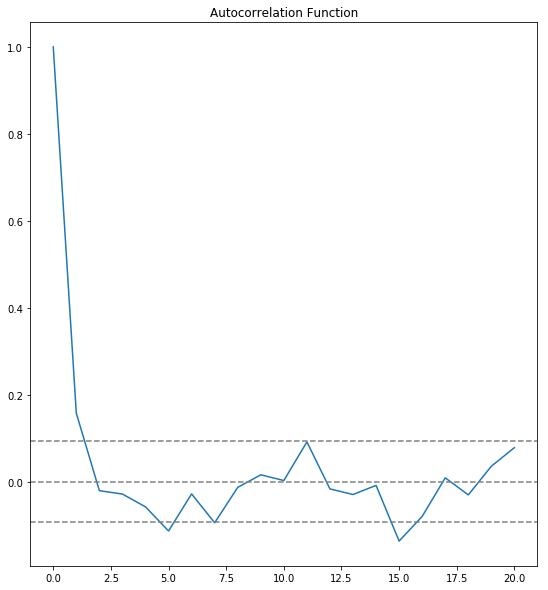

In [282]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

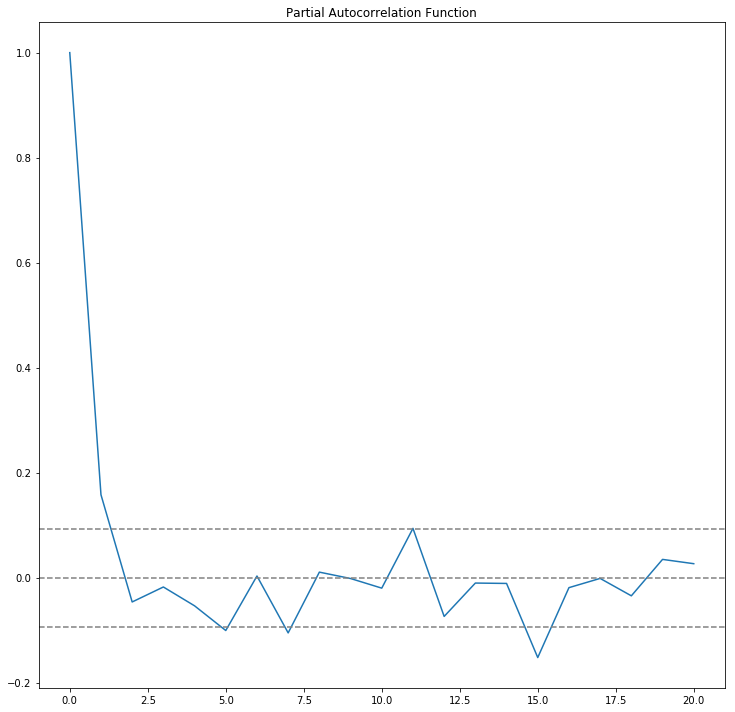

In [283]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

1 2


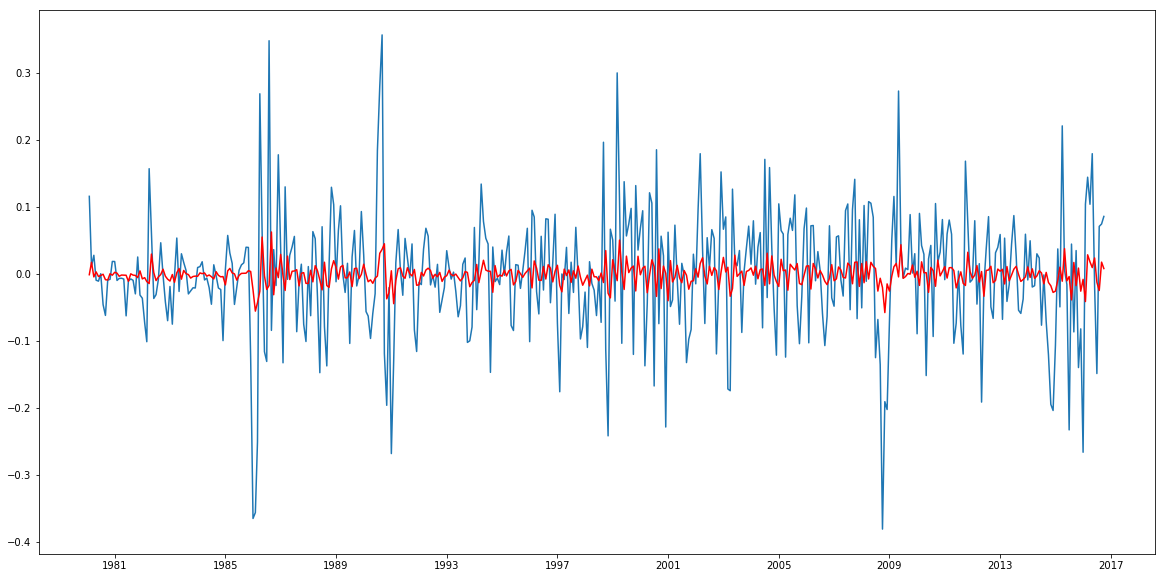

In [292]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
print(results_AR.fittedvalues.ndim, ts_log_diff.ndim)